# 気象データから1時間後の降雨を予測する

概要：過去の気象データを学習して、現時点の気象データから１時間後の降雨の有無を予測する

***

## １．データの概要を把握する

### CSVファイルからデータを読み込む

In [1]:
#ライブラリーを読み込む
import pandas as pd
pd.set_option('precision', 2)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

# データの読込と表示
df_orig = pd.read_csv(
    "17_preprocessed.csv",
    sep="," ,
    skiprows = 1,
    header= 1,
    encoding = "Shift_JISx0213").set_index("年月日時")
df_orig.head()            # 統計量の表示

df_orig = df_orig[24 * 30:-24*30] # 冬は雨ではなく雪のため除く

***

### 統計データを表示

In [2]:
df_orig.describe()

,気温(℃),降水量(mm),降雪(cm),積雪(cm),日照時間(時間),風速(m/s),風向,露点温度(℃),蒸気圧(hPa),相対湿度(％),海面気圧(hPa),現地気圧(hPa),日射量(MJ/㎡),天気,視程(km),雲量(10分比)
count,7319.00,7319.00,7.32e+03,7319.00,7319.00,7319.00,7319.00,7319.00,7319.00,7319.00,7319.00,7319.00,7319.00,7319.00,7319.00,7319.00
mean,14.22,0.15,7.65e-03,0.62,0.23,2.49,2.71,9.19,13.48,74.05,1013.34,964.43,0.66,4.17,18.62,7.43
std,9.16,1.09,1.17e-01,2.48,0.38,1.77,1.86,8.90,7.43,17.06,7.43,6.35,0.97,3.16,7.73,3.57
min,-6.80,0.00,0.00e+00,0.00,0.00,0.00,0.00,-13.30,2.20,12.00,982.40,935.10,0.00,1.00,0.70,0.00
25%,6.50,0.00,0.00e+00,0.00,0.00,1.10,1.18,1.20,6.70,63.00,1008.30,960.50,0.00,2.00,15.00,5.00
50%,15.20,0.00,0.00e+00,0.00,0.00,1.90,2.36,9.90,12.20,77.00,1012.70,964.30,0.04,4.00,20.00,10.00
75%,22.00,0.00,0.00e+00,0.00,0.40,3.60,4.32,16.70,19.00,88.00,1018.70,968.60,1.10,4.00,25.00,10.00
max,34.80,52.00,4.00e+00,21.00,1.00,11.10,5.89,24.80,31.20,100.00,1030.40,978.70,3.78,15.00,40.00,10.00


***

### データを標準化する

In [3]:
df =  (df_orig - df_orig.mean()) / (df_orig.std())
df.head()

,気温(℃),降水量(mm),降雪(cm),積雪(cm),日照時間(時間),風速(m/s),風向,露点温度(℃),蒸気圧(hPa),相対湿度(％),海面気圧(hPa),現地気圧(hPa),日射量(MJ/㎡),天気,視程(km),雲量(10分比)
年月日時,,,,,,,,,,,,,,,,
2017/1/31 1:00,-1.70,-0.14,-0.07,4.99,-0.61,-0.39,-1.03,-1.34,-1.14,0.99,0.57,0.18,-0.68,2.48,-2.02,0.72
2017/1/31 2:00,-1.70,-0.14,8.51,5.39,-0.61,0.34,-1.46,-1.47,-1.19,0.52,0.69,0.33,-0.68,2.48,-2.02,0.72
2017/1/31 3:00,-1.66,-0.14,-0.07,4.99,-0.61,1.19,1.71,-1.81,-1.33,-0.59,0.86,0.51,-0.68,2.48,-0.47,0.72
2017/1/31 4:00,-1.89,-0.14,-0.07,4.99,-0.61,0.12,-0.82,-1.62,-1.26,0.64,1.06,0.67,-0.68,2.48,-0.47,0.72
2017/1/31 5:00,-1.89,-0.14,-0.07,4.99,-0.61,2.27,-0.61,-1.62,-1.26,0.64,1.19,0.83,-0.68,2.48,-0.47,0.72


### 相関係数を表示

In [4]:
df_corr = df.corr()
df_corr

,気温(℃),降水量(mm),降雪(cm),積雪(cm),日照時間(時間),風速(m/s),風向,露点温度(℃),蒸気圧(hPa),相対湿度(％),海面気圧(hPa),現地気圧(hPa),日射量(MJ/㎡),天気,視程(km),雲量(10分比)
気温(℃),1.00,4.69e-02,-1.12e-01,-4.12e-01,2.03e-01,1.29e-01,8.71e-02,0.90,0.87,-2.14e-01,-5.30e-01,-0.33,0.33,-0.10,-1.69e-02,1.68e-01
降水量(mm),0.05,1.00e+00,4.27e-02,-1.64e-02,-8.25e-02,-4.94e-03,-1.51e-02,0.11,0.12,1.68e-01,-1.08e-01,-0.11,-0.08,0.18,-9.22e-02,7.88e-02
降雪(cm),-0.11,4.27e-02,1.00e+00,2.47e-01,-3.74e-02,-1.79e-02,-3.37e-02,-0.08,-0.07,7.71e-02,-8.26e-03,-0.04,-0.04,0.13,-7.72e-02,4.12e-02
積雪(cm),-0.41,-1.64e-02,2.47e-01,1.00e+00,-2.89e-03,-3.54e-02,-5.28e-02,-0.39,-0.30,5.58e-02,1.44e-01,0.05,-0.04,0.13,-5.65e-03,-6.18e-02
日照時間(時間),0.20,-8.25e-02,-3.74e-02,-2.89e-03,1.00e+00,2.16e-01,-2.04e-01,-0.08,-0.07,-6.15e-01,5.34e-03,0.06,0.85,-0.27,5.66e-02,-3.26e-01
風速(m/s),0.13,-4.94e-03,-1.79e-02,-3.54e-02,2.16e-01,1.00e+00,-8.61e-02,-0.04,-0.06,-4.02e-01,-1.74e-01,-0.16,0.28,0.07,1.57e-01,3.46e-02
風向,0.09,-1.51e-02,-3.37e-02,-5.28e-02,-2.04e-01,-8.61e-02,1.00e+00,0.13,0.12,1.05e-01,4.68e-03,0.03,-0.20,-0.07,2.14e-03,8.61e-03
露点温度(℃),0.90,1.13e-01,-8.40e-02,-3.86e-01,-7.62e-02,-3.89e-02,1.32e-01,1.00,0.97,2.35e-01,-5.23e-01,-0.35,0.02,0.06,-1.09e-01,2.94e-01
蒸気圧(hPa),0.87,1.24e-01,-7.28e-02,-3.04e-01,-7.10e-02,-6.21e-02,1.23e-01,0.97,1.00,2.39e-01,-5.29e-01,-0.36,0.03,0.07,-1.04e-01,2.89e-01
相対湿度(％),-0.21,1.68e-01,7.71e-02,5.58e-02,-6.15e-01,-4.02e-01,1.05e-01,0.23,0.24,1.00e+00,-2.53e-04,-0.06,-0.66,0.37,-2.36e-01,2.80e-01


### 相関係数の大きい要素のみ表示

In [5]:
df_corr.applymap(lambda x: x if abs(x) > 0.3 else "---")

,気温(℃),降水量(mm),降雪(cm),積雪(cm),日照時間(時間),風速(m/s),風向,露点温度(℃),蒸気圧(hPa),相対湿度(％),海面気圧(hPa),現地気圧(hPa),日射量(MJ/㎡),天気,視程(km),雲量(10分比)
気温(℃),1,---,---,-0.41,---,---,---,0.9,0.87,---,-0.53,-0.33,0.33,---,---,---
降水量(mm),---,1,---,---,---,---,---,---,---,---,---,---,---,---,---,---
降雪(cm),---,---,1,---,---,---,---,---,---,---,---,---,---,---,---,---
積雪(cm),-0.41,---,---,1,---,---,---,-0.39,-0.3,---,---,---,---,---,---,---
日照時間(時間),---,---,---,---,1,---,---,---,---,-0.62,---,---,0.85,---,---,-0.33
風速(m/s),---,---,---,---,---,1,---,---,---,-0.4,---,---,---,---,---,---
風向,---,---,---,---,---,---,1,---,---,---,---,---,---,---,---,---
露点温度(℃),0.9,---,---,-0.39,---,---,---,1,0.97,---,-0.52,-0.35,---,---,---,---
蒸気圧(hPa),0.87,---,---,-0.3,---,---,---,0.97,1,---,-0.53,-0.36,---,---,---,---
相対湿度(％),---,---,---,---,-0.62,-0.4,---,---,---,1,---,---,-0.66,0.37,---,---


### 降水量と他データとの相関

In [6]:
pd.reset_option("display.precision")
pd.DataFrame(df_corr["降水量(mm)"])

,降水量(mm)
気温(℃),0.046919
降水量(mm),1.000000
降雪(cm),0.042667
積雪(cm),-0.016431
日照時間(時間),-0.082510
風速(m/s),-0.004945
風向,-0.015147
露点温度(℃),0.113077
蒸気圧(hPa),0.124163
相対湿度(％),0.167913


## → <font color="red">残念ながら降水量と相関の強いデータはなし</font>

***

# ２．次ステップの方向づけ  
* 相関係数からでは降水量の予測に適した要素を見つけられなかった。
* ニューラルネットワークから降水量を推定する<br>

### 学習設定
* １か月分のデータをテストデータとする。

In [7]:
MAX_NEST_DEPTH = 10
TEST_DATA_LENGTH = 24 * 30  # 1か月分をテストデータとする

### データ準備

In [8]:
src = np.array(df.drop('降水量(mm)', axis=1))
src = np.delete(src, -1, axis = 0)  # 最終のデータは予測には使用しない（できない）ため削除

In [9]:
target = np.array(df['降水量(mm)'])
target = np.delete(target, 0, axis = 0)  # 先頭のデータは予測できないため削除
#target = np.round(target) # DecisionTreeClassifierは整数である必要あり。
target = [(True if t > min(target) else False) for t in target] # 雨が少しでも降れば「降雨あり」

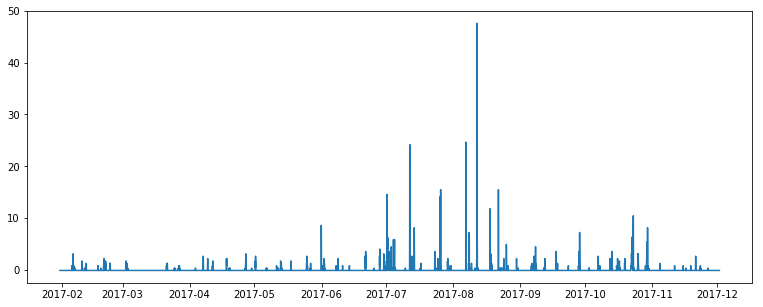

In [10]:
plt.subplots(figsize=(13, 5))
index = [datetime.datetime.strptime(i, '%Y/%m/%d %H:%M') for i in df.index]
plt.plot(index, df['降水量(mm)'].values)
plt.show()

　　　　　　　　　　　　　　　　　　　　　　　　　１時間ごとの降雨量

***
## トレーニング開始

In [11]:
src_train = src[:-TEST_DATA_LENGTH]
target_train = target[:-TEST_DATA_LENGTH]

### ニューラルネットワークを実行

In [12]:
from sklearn.neural_network import MLPClassifier
mlpModel = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=(20, ))

In [13]:
mlpModel.fit(src_train, target_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [14]:
predicted = mlpModel.predict(src_train)
print(len(target_train), "回中", sum(predicted == target_train), "回で的中（", round(sum(predicted == target_train) / len(target_train) * 100), "%）")

6598 回中 6258 回で的中（ 95.0 %）


***
## １か月の降雨を予測する

In [15]:
src_test = src[-TEST_DATA_LENGTH:]
target_test = target[-TEST_DATA_LENGTH:]
predicted = mlpModel.predict(src_test)

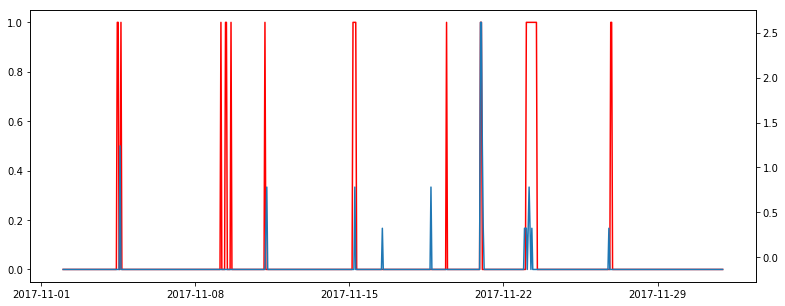

In [16]:
fig, ax1 = plt.subplots(figsize=(13, 5))
index = [datetime.datetime.strptime(i, '%Y/%m/%d %H:%M') for i in df.index[-TEST_DATA_LENGTH:]]
ax1.plot(index, predicted, color='r')
ax2 = ax1.twinx()
ax2.plot(index, df['降水量(mm)'].values[-TEST_DATA_LENGTH:])
plt.show()

### 予測した結果

In [17]:
print(TEST_DATA_LENGTH, "回中", sum(predicted == target_test), "回で的中（", round(sum(predicted == target_test) / len(target_test) * 100), "%）")

720 回中 689 回で的中（ 96.0 %）


<font color="blue">青線：降水量</font>  
<font color="red">赤線：1時間後の雨を予測した結果</font>

In [18]:
pair = np.array([target_test, predicted]).T
result = [sum(i[0] == i[1] and i[0] == True for i in pair),    # 降雨あり、予測もありの回数
          sum(i[0] == i[1] and i[0] == False for i in pair),   # 降雨なし、予測もなしの回数
          sum(i[0] == False and i[1] == True for i in pair),   # 降雨なし、予測はありの回数
          sum(i[0] == True and i[1] == False for i in pair)]   # 降雨あり、予測はなしの回数

In [19]:
pd.DataFrame(np.array([["有", "無", "無", "有"], ["有", "無", "有", "無"], result]).T, columns=["実際", "予測", "回数"])

,実際,予測,回数
0,有,有,8
1,無,無,681
2,無,有,21
3,有,無,10


***
# ３．結果
* 相関係数では相関のない要素でも、決定木を使用した要素抽出で的中率は96%となった。
* 決定木と異なりニューラルネットワークによる予測ではどのように判定したかの分析は難易度が高い。
* 適切なパラメータ設定値が課題である。